In [1]:
import json, pickle
import glob, os

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem, FakeGuadalupe

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel

from functools import partial

In [2]:
backend = FakeGuadalupe()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 4

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [4]:
def get_zne_expval(circ,
                   obs: str,
                   extrapolator,
                   backend,
                   noise_factors = (1, 3),
                   amplifier=LocalFoldingAmplifier(gates_to_fold=2),
                   shots:int=10000,
                   ) -> float:
    """Returns the zero-noise expectation values for a list of observables `obs` of a circuit `circ`
    Inputs:
    obs (list[str]): Observables in Endian convention (e.g. 'IIZ' is the Z operator on the 0th qubit) for the PHYSICAL qubits
    mapping (list[int]): Mapping between logical and physical qubits, e.g. mapping[0] is the physical qubit for logical qubit 0
    """
    observable = SparsePauliOp(obs)

    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors,
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )

    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    values = job.result().values
    # we use a different convention where +1 is the eigenvalue for |1> state, because cal_z_exp assumes 0 is -Z and 1 is +Z
    values *= -1

    return values.tolist()

def get_measurement_qubits(qc, num_qubit):
        measurement_qubits = []
        for measurement in range(num_qubit-1, -1, -1):
            measurement_qubits.append(qc.data[-1-measurement][1][0].index)
        return measurement_qubits

def get_all_circuit_meas_mapping(circs):
    out = []
    for circ in circs:
        mapping = get_measurement_qubits(circ, 16)
        mapping = mapping[::-1]
        for i in range(16):
            if i not in mapping:
                mapping = mapping + [i]
        out.append(mapping)
    return out

In [5]:
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.circuit.exceptions import CircuitError
import scipy

def generate_data(generating_func, num_qubit_list, save_path: str, n_entries_per_file: int, run_config_n, do_zne=False):
    for n in num_qubit_list:
        entries = []

        for _ in tqdm(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    circuit = generating_func(num_qubit=n)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError, CircuitError) as e:
                    print(f"Ran into an error:, {e}")

            print('!')
            job_ideal = execute(circuit, **run_config_ideal)
            print('!!')
            job_noisy = execute(circuit, **run_config_n)


            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)
            mitigated = None

            print('!!!')
            if do_zne:
                degree = 1
                extrapolator = PolynomialExtrapolator(degree=degree)
                mitigated = []

                # ob_list has single Z measurement on the first qubit in the last position, i.e., 'ZIIII' is measuring the top qubit (Non-endian notation)
                ob_list = np.array(['I'*i+'Z'+'I'*(16-i-1) for i in range(16)][::-1])
                mapping = get_all_circuit_meas_mapping(circuit)
                ob_list = ob_list[np.array(mapping)].tolist()
                for obs in ob_list:
                    ############################ Change the backend #######################################
                    mitigated += get_zne_expval(circuit, obs, extrapolator, backend_noisy)
                    #######################################################################################
                print([round(x, 3) for x in mitigated])

            to_append = dict()
            to_append['circuit'] = circuit
            to_append['noisy_exp_val'] = noisy_exp_val
            to_append['ideal_exp_val'] = ideal_exp_val
            to_append['zne_mitigated'] = mitigated
            entries.append(to_append)

        path = f"{save_path}/q{n}.pk"
        with open(path, "wb") as f:
            pickle.dump(entries, f)

# Random Circuit

In [6]:
import qiskit
def get_active_qubits_dynamics(circuit):
    operations = circuit.data
    active_qubits = set()

    for op in operations:
        if isinstance(op[0], qiskit.circuit.Barrier) or isinstance(op[0], qiskit.circuit.Delay):
            continue
        for qubit in op[1]:
            active_qubits.add(qubit.index)

    return active_qubits

def remove_idle_qubits(circuit, layout):
    # Get active qubits, which excludes 'Delay' and 'Barrier' operations
    active_qubits = get_active_qubits_dynamics(circuit)

    # Create a new list ordered_qubits, preserving the order in layout
    ordered_qubits = [qubit for qubit in layout if qubit in active_qubits]

    # Keep the original ClassicalRegisters intact
    new_qc = QuantumCircuit(len(ordered_qubits))
    for cr in circuit.cregs:
        new_qc.add_register(cr)

    # Go through each instruction and replace the qubit indices with the indices of ordered qubits
    for instr, qargs, cargs in circuit.data:
        ordered_qarg_indices = [ordered_qubits.index(qubit.index) for qubit in qargs if qubit.index in ordered_qubits]
        # Since we're keeping the classical bits as they were, there's no need to change the indices
        if ordered_qarg_indices:  # If list is not empty, means qubits are involved in operation
            new_qc.append(instr, qargs=ordered_qarg_indices, cargs=cargs)

    return new_qc

from qiskit.circuit.quantumregister import Qubit
def get_circuit_initial_layout(circuit):
    out = []
    for transpiled_index, qbit in circuit.layout.initial_layout.get_physical_bits().items():
        if qbit._register.name == 'q':
            out.append(transpiled_index)
    return out

In [13]:
import warnings
warnings.filterwarnings('ignore')

def construct_random_circuit(two_q_gate_depth_post_trans, be, num_qubit):
    layout = list(range(num_qubit))

    if (two_q_gate_depth_post_trans, num_qubit) == (18, 10): factor = 3
    elif (two_q_gate_depth_post_trans, num_qubit) == (18, 12): factor = 6
    elif (two_q_gate_depth_post_trans, num_qubit) == (18, 16): factor = 9
    else: raise NotImplementedError

    if not two_q_gate_depth_post_trans:
        d = np.random.randint(1, 6)
        rc = transpile(random_circuit(num_qubit, d, 1, measure=True), backend=be, optimization_level=0, initial_layout=layout)

    elif 1 <= two_q_gate_depth_post_trans <= 8:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=0, initial_layout=layout)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=0, initial_layout=layout)

    elif 8 <= two_q_gate_depth_post_trans <= 18:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=0, initial_layout=layout)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            print(rc.depth(filter_function=lambda x: x[0].num_qubits == 2))
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=be, optimization_level=0, initial_layout=layout)
    else:
        raise NotImplementedError

    rc = remove_idle_qubits(rc, layout)
    return rc

random seed fixed to 0
11
39
22
17
19
28
8
14
10
33
11
30
8
17
19
20
22
10
24
25
9
16
15
22
9
11
20
21
28
30
28
23
12
11
17
23
16
16
20
19
13
11
42
38
38
26
14
17
8
34
25


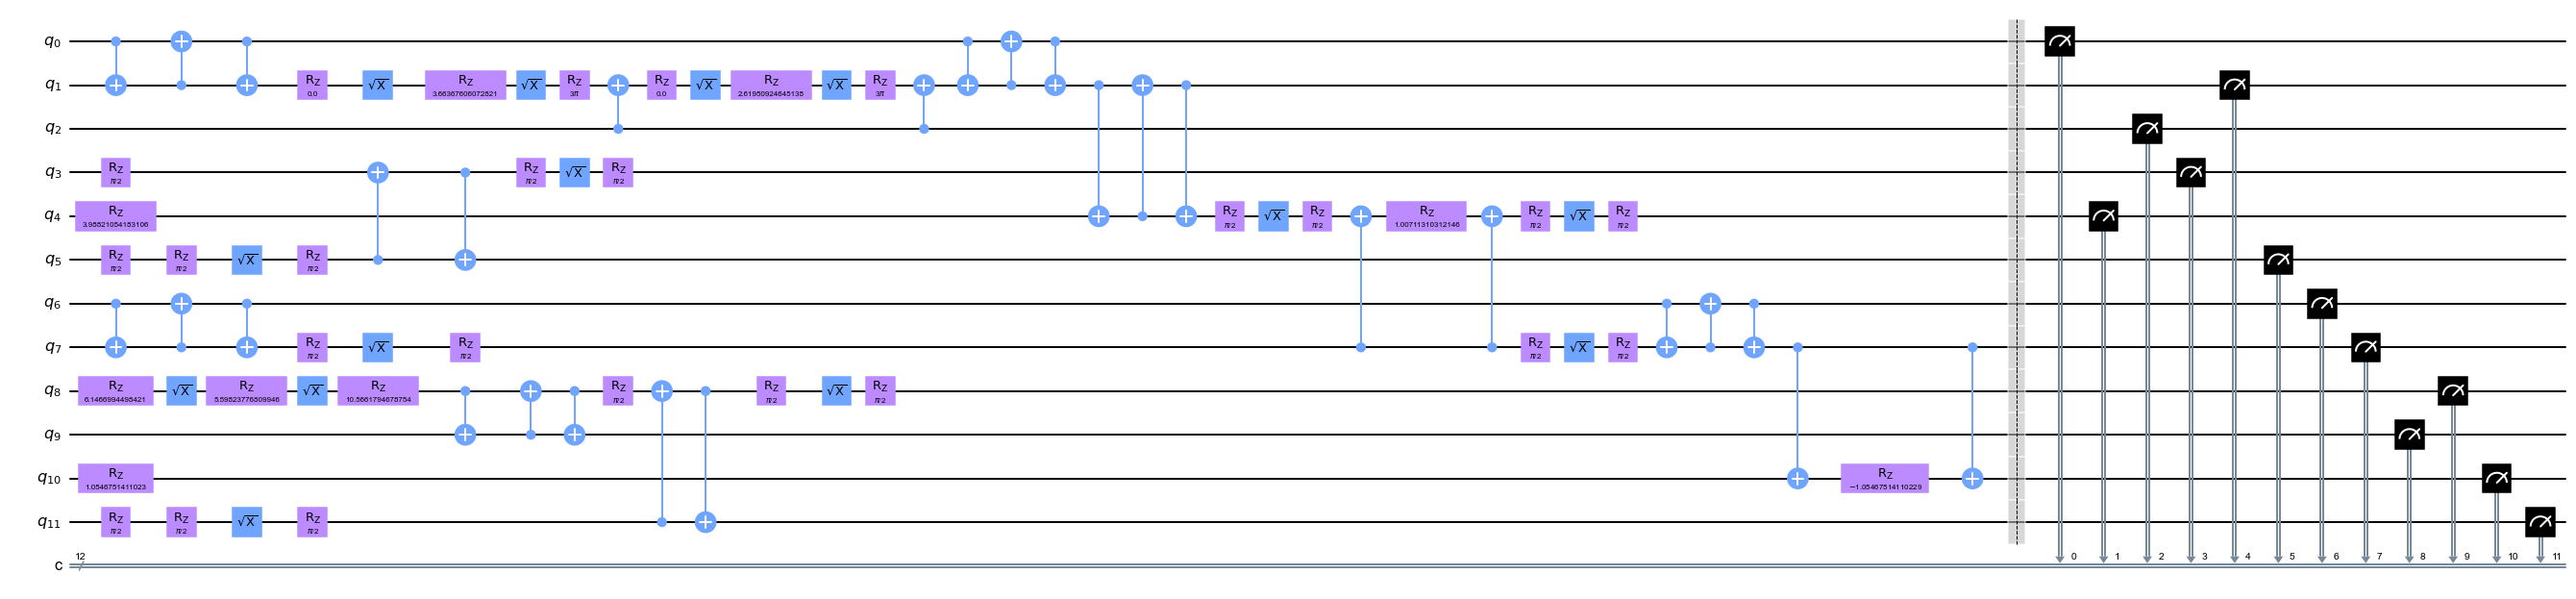

In [11]:
fix_random_seed(0)
# circuit = transpile(construct_random_circuit(2), backend=backend_noisy, optimization_level=3)
# ideal_circuit = construct_random_circuit(18, backend_ideal, 12)
noisy_circuit = construct_random_circuit(18, backend_noisy, 12)
noisy_circuit.draw('mpl', fold=-1)

In [12]:
import time
start = time.time()
job = backend_noisy.run(noisy_circuit, shots=10000)
end = time.time()
print(end-start)

0.007967948913574219


In [ ]:
ideal_circuit.draw('mpl', fold=-1)

In [11]:
transpile(noisy_circuit, backend_noisy, optimization_level=0).depth(lambda x: x[0].num_qubits == 2)

18

In [14]:
# fix_random_seed(0)
# num_qubit_list = [12]
# generate_data(partial(construct_random_circuit, be=backend_noisy, two_q_gate_depth_post_trans=18), num_qubit_list, './data/extra_random_circuits/train', 500, run_config_n=run_config_noisy)

random seed fixed to 0


  0%|          | 0/500 [00:00<?, ?it/s]

Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
Ran into an error:, 'The amount of qubit(1)/clbit(0)

In [14]:
fix_random_seed(1)
num_qubit_list = [12]
generate_data(partial(construct_random_circuit, be=backend_noisy, two_q_gate_depth_post_trans=18), num_qubit_list, './data/extra_random_circuits/val', 200, run_config_n=run_config_noisy, do_zne=True)

random seed fixed to 1


  0%|          | 0/200 [00:00<?, ?it/s]

20
13
41
26
Ran into an error:, 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'
11
11
!
!!
!!!


AttributeError: 'CircuitInstruction' object has no attribute 'data'